# **read dataset**

In [2]:
import netCDF4

file_path = "./no2_averages_4years.nc"
ds = netCDF4.Dataset(file_path)

# Lihat seluruh variabel yang tersedia
print("📦 Variabel dalam file:")
print(ds.variables.keys())

# Misal variabel utama bernama "NO2"
no2 = ds.variables["NO2"][:]

# Waktu (biasanya dalam format 'days since ...' atau sejenis)
time = ds.variables["t"][:]

# Konversi waktu ke format tanggal jika punya atribut 'units'
try:
    time_units = ds.variables["t"].units
    dates = netCDF4.num2date(time, units=time_units)
except Exception:
    dates = time  # fallback kalau tidak ada units

# Tampilkan 10 baris pertama
print("\n📅 Contoh data pertama:")
for i in range(min(10, len(no2))):
    print(f"{dates[i]} | NO2: {no2[i]}")

📦 Variabel dalam file:
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])

📅 Contoh data pertama:
2021-01-01 00:00:00 | NO2: [[--]]
2021-01-02 00:00:00 | NO2: [[--]]
2021-01-03 00:00:00 | NO2: [[--]]
2021-01-04 00:00:00 | NO2: [[--]]
2021-01-05 00:00:00 | NO2: [[--]]
2021-01-06 00:00:00 | NO2: [[--]]
2021-01-07 00:00:00 | NO2: [[--]]
2021-01-08 00:00:00 | NO2: [[--]]
2021-01-09 00:00:00 | NO2: [[--]]
2021-01-10 00:00:00 | NO2: [[--]]


## Transform data from NC to CSV

In [3]:
import netCDF4
import pandas as pd
import numpy as np

# 1. Baca file NetCDF
file_path = "./no2_averages_4years.nc"
ds = netCDF4.Dataset(file_path)

# 2. Tampilkan struktur file
print(ds)

# 3. Ambil variabel yang tersedia
print(ds.variables.keys())

# 4. Ambil variabel waktu dan NO2
time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

# 5. Konversi waktu ke datetime
time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

# 6. Jika data NO2 berdimensi lebih dari 1 (misalnya [time, lat, lon]),
# kita rata-ratakan agar menjadi satu nilai per waktu
if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

# 7. Buat DataFrame
df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

# 8. Simpan ke CSV
df.to_csv("./no2_KwanyarBarat.csv", index=False)
print("✅ File no2_KwanyarBarat.csv berhasil dibuat.")
print(df.head())

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.9
    institution: Copernicus Data Space Ecosystem openEO API - 0.68.0a10.dev20250930+2976
    description: 
    title: 
    dimensions(sizes): t(1736), y(1), x(1)
    variables(dimensions): int32 t(t), float64 x(x), float64 y(y), |S1 crs(), float32 NO2(t, y, x)
    groups: 
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])
✅ File no2_KwanyarBarat.csv berhasil dibuat.
                  time  NO2
0  2021-01-01 00:00:00  NaN
1  2021-01-02 00:00:00  NaN
2  2021-01-03 00:00:00  NaN
3  2021-01-04 00:00:00  NaN
4  2021-01-05 00:00:00  NaN


## Interpolation NaN value

In [10]:
import pandas as pd
import numpy as np

# --- 1. Persiapan Data (Ulangi Langkah Sebelumnya) ---
try:
    # Ganti nama file jika perlu
    df = pd.read_csv("./no2_KwanyarBarat.csv")
except FileNotFoundError:
    print("❌ Error: Pastikan file 'no2_KwanyarBarat.csv' ada di direktori yang sama.")
    raise

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.set_index('time')
df['NO2'] = df['NO2'].interpolate(method='time')
df = df[['NO2']].dropna() # Pastikan hanya kolom NO2 yang tersisa

n_lags = 4
supervised = pd.DataFrame()

# Membuat fitur lag (t-4 hingga t-1)
for i in range(n_lags, 0, -1):
    # Menggunakan kolom 'NO2' dari DataFrame asli
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

# Menetapkan kolom target NO2(t)
supervised['NO2(t)'] = df['NO2']

# Menghapus NaN yang disebabkan oleh shifting (4 baris pertama)
supervised = supervised.dropna()

# --- 2. Tampilkan Output yang Diminta ---

print("NO2  20") # Baris ini sepertinya data dari .value_counts() atau info lain
print("Dtype: int64\n") # Baris ini tidak bisa direplikasi langsung tanpa manipulasi

print("📅 Head of Data:")
# Menampilkan 5 baris pertama DataFrame supervised
print(supervised.head())

print("\n📦 Data info:")
supervised.info()

print("\n--- Head Data (Tanpa Notasi Ilmiah) ---")
# Gunakan pengaturan Pandas sementara untuk menonaktifkan notasi ilmiah
with pd.option_context('display.float_format', '{:.6f}'.format):
    print(supervised.head())

NO2  20
Dtype: int64

📅 Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2021-01-25  0.000055  0.000052  0.000049  0.000046  0.000043
2021-01-26  0.000052  0.000049  0.000046  0.000043  0.000041
2021-01-27  0.000049  0.000046  0.000043  0.000041  0.000038
2021-01-28  0.000046  0.000043  0.000041  0.000038  0.000040
2021-01-29  0.000043  0.000041  0.000038  0.000040  0.000042

📦 Data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1712 entries, 2021-01-25 to 2025-10-18
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NO2(t-4)  1712 non-null   float64
 1   NO2(t-3)  1712 non-null   float64
 2   NO2(t-2)  1712 non-null   float64
 3   NO2(t-1)  1712 non-null   float64
 4   NO2(t)    1712 non-null   float64
dtypes: float64(5)
memory usage: 80.2 KB

--- Head Data (Tanpa Notasi Ilmiah) ---
            NO2(t-4)  NO2(t-3)  NO2(t-2)  

## Normilize dataset using min-max

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore') # Untuk mengabaikan peringatan pandas/sklearn

try:
    df = pd.read_csv("./no2_KwanyarBarat.csv")
except FileNotFoundError:
    print("❌ Error: Pastikan file 'no2_KwanyarBarat.csv' ada di direktori yang sama.")
    raise

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.set_index('time')
df['NO2'] = df['NO2'].interpolate(method='time')
df = df.dropna() # Drop sisa NaN jika ada

n_lags = 4
supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

supervised = supervised.dropna()

print("... Sebelum Normalisasi:")
print(supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']].head())
print("\n" * 2)

scaler = MinMaxScaler()
# Normalisasi semua kolom (fitur dan target)
scaled_values = scaler.fit_transform(supervised.values)

# Kembalikan ke DataFrame agar dapat memiliki label kolom dan indeks waktu
scaled_df = pd.DataFrame(scaled_values, columns=supervised.columns, index=supervised.index)

print("Sesudah Normalisasi:")
print(scaled_df[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']].head().reset_index(drop=True))

... Sebelum Normalisasi:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2021-01-25  0.000055  0.000052  0.000049  0.000046
2021-01-26  0.000052  0.000049  0.000046  0.000043
2021-01-27  0.000049  0.000046  0.000043  0.000041
2021-01-28  0.000046  0.000043  0.000041  0.000038
2021-01-29  0.000043  0.000041  0.000038  0.000040



Sesudah Normalisasi:
   NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.761105  0.744373  0.727642  0.710910
1  0.744373  0.727642  0.710910  0.694178
2  0.727642  0.710910  0.694178  0.677446
3  0.710910  0.694178  0.677446  0.660715
4  0.694178  0.677446  0.660715  0.673524


## Create model using KNN Regression

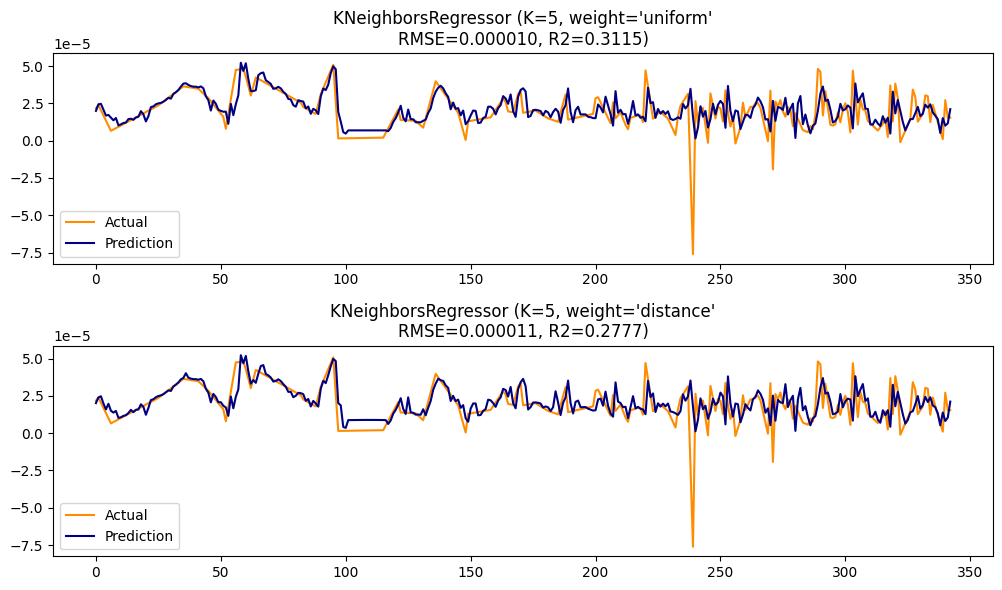

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'darkorange', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'navy', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()